PCA is commonly used with high dimensional data.  One type of high dimensional data is images. In this example, I will show you a similar use case using images of numbers.

A classic example of working with image data is the MNIST dataset, which was open sourced in the late 1990s by researchers across Microsoft, Google, and NYU.  I have linked more information about the dataset below this video in the workbook:  http://yann.lecun.com/exdb/mnist/

To get started, let's import the libraries we will need for the rest of the notebook.

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The dataset has 42,000 images in the training dataset, and another 28,000 images in a test set.  Let's read in the datasets and see what they look like.  If you would like to follow along with me, you can open the workspace below this video in another window and work along with me.  Let's take a closer look at the data.

In [3]:
train = pd.read_csv('./data/train.csv')
train.fillna(0, inplace=True)

Loading the data may take a bit of time, but once it is loaded, we will focus on the training dataset. 

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,6304.000000,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,...,6304.000000,6304.000000,6304.000000,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0
mean,4.440355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.139594,0.142291,0.026967,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.885613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.099940,5.531089,1.675547,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,130.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From a header and the describe of the data, we can see that the data has a label column with what digit was created, and the pixels for each part of the image are the features.  The values for the pixels are between 0 and 255.  You can find an article on the pixel values in the article below in the notebook. https://homepages.inf.ed.ac.uk/rbf/HIPR2/value.htm

Given what we know about the data, let's split the label off and put the images in their own matrix.

In [6]:
# save the labels to a Pandas series target
y = train['label']
# Drop the label feature
X = train.drop("label",axis=1)

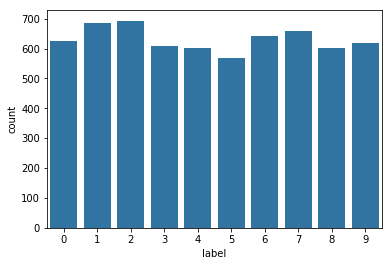

In [7]:
sns.countplot(y, color = sns.color_palette()[0]); #a very quick look at the data shows that all the labels appear roughly 4k times

Let's take a look at what a few of the numbers look like with this little helper function. 

In [8]:
def show_images(num_images):
    '''
    This function plots the num_images provided of MNIST dataset. 
    
    INPUT: num_images - int - The number of images you would like to view.
           Mod 10 of num_images should be 0 and it should be fewer than 101 images.
    OUTPUT: A figure with the images shown for the training data.
    '''
    if num_images % 10 == 0 and num_images <= 100:
        for digit_num in range(0,num_images): 
            plt.subplot(num_images/10,10,digit_num+1) #create subplots
            mat_data = X.iloc[digit_num].values.reshape(28,28)  #reshape images
            plt.imshow(mat_data) #plot the data
            plt.xticks([]) #removes numbered labels on x-axis
            plt.yticks([]) #removes numbered labels on y-axis
    else:
        print('That is not the right input, please read the docstring before continuing.')

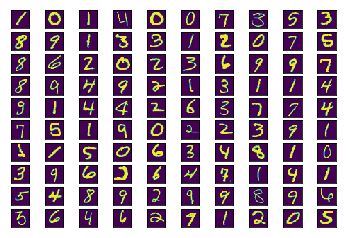

In [9]:
show_images(100)

Some of these look pretty easy to identify, and others not so much... I wrote another helper function to be able to see each of the first 50 images of any one type of number.

In [10]:
def show_images_by_digit(digit_to_see):
    '''
    This function plots the digits_to_see provided of MNIST dataset. 
    
    INPUT: digits_to_see - int - A number between 0 and 9 of what you want to see.
    OUTPUT: A figure with the images shown for the training data.
    '''
    if digit_to_see in list(range(10)):
        indices = np.where(y == digit_to_see) # pull indices for num of interest
        for digit_num in range(0,50): 
            plt.subplot(5,10, digit_num+1) #create subplots
            mat_data = X.iloc[indices[0][digit_num]].values.reshape(28,28)  #reshape images
            plt.imshow(mat_data) #plot the data
            plt.xticks([]) #removes numbered labels on x-axis
            plt.yticks([]) #removes numbered labels on y-axis   
    else:
        print('That is not the right input, please read the docstring before continuing.')

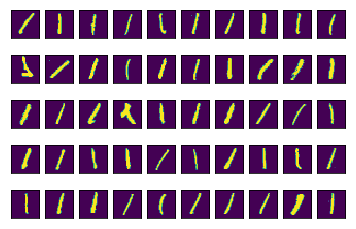

In [11]:
show_images_by_digit(1)

Some of these ones are pretty wild looking...  One common way to use PCA is to reduce the dimensionality of high dimensionality data that you want to use for prediction, but the results seem to be overfitting (potentially because their is a lot of noise in the data.  Which can certainly be the case with image data).

Let's take a first pass on creating a simple model to predict the values of the images using all of the data.

[[202   0   0   0   0   0   7   0   0   0]
 [  0 235   1   0   0   2   1   2   2   0]
 [  1   6 212   1   2   1   0   4   1   0]
 [  2   0   5 174   0   4   1   1   2   2]
 [  0   0   1   0 168   0   3   0   0   6]
 [  3   2   0   4   0 173   2   0   2   0]
 [  2   0   1   0   1   1 206   0   0   0]
 [  0   0   7   0   6   0   0 207   2   3]
 [  1   2   0   4   0   3   0   0 190   2]
 [  1   0   1   3  10   2   0   2   5 184]]
AxesSubplot(0.125,0.125;0.62x0.755)
0.937530033638


0.93753003363767418

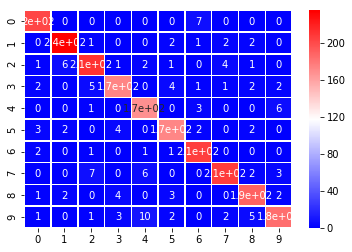

In [12]:
#Because we will fit this more than once, might as well make a function
def fit_random_forest_classifier(X, y):
    '''
    INPUT: names are pretty self explanatory
    OUTPUT: none - prints the confusion matrix and accuracy
    '''
    #First let's create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #We could grid search and tune, but let's just fit a simple model to see how it does
    #instantiate
    clf = RandomForestClassifier(n_estimators=100, max_depth=None)

    #fit
    clf.fit(X_train, y_train)

    #predict
    y_preds = clf.predict(X_test)

    #score
    mat = confusion_matrix(y_test, y_preds)
    print(mat)
    print(sns.heatmap(mat, annot=True, cmap='bwr', linewidths=.5))
    acc = accuracy_score(y_test, y_preds)
    print(acc)
    return acc
    
fit_random_forest_classifier(X, y)

The above model does pretty well on the test set using all of the data, let's see how well a model can do with a much lower number of features.  Perhaps, we can do as well or better by reducing the noise in the original features.

Working with unsupervised techniques in scikit learn follows a similar process as working with supervised techniques, but excludes predicting and scoring, and instead we just need to transform our data.  Often the fit and transform are done all in one step.

1. Instantiate
2. Fit 
3. Transform 

It is worth mentioning that because all of our features are on the same scale from 0 to 255, scaling isn't super necessary here.  At the same time, I usually try to create processes that are extendible without having to think and dive into the details again.  Without standardizing, this process would only work for data that was already scaled.

You can use the below function to perform PCA on this dataset, but also any other dataset.

In [13]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [14]:
pca, X_pca = do_pca(2, X)

In [15]:
X_pca.shape

(6304, 2)

In [16]:
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[[109   0  42   8   8   7  27   0   8   0]
 [  0 210   0   4   1   7   4   7   8   2]
 [ 38   2  72  27  14  29  32   1  10   3]
 [ 11   1  35  23  22  25  25  11  24  14]
 [  6   5  20  18  47  16  16  11  11  28]
 [  7   7  29  25  17  23  28   6  34  10]
 [ 27   6  49  19   9  29  42   3  26   1]
 [  1   5   4   9  32  12   2  91   9  60]
 [  5   6  26  33  19  30  28   7  40   8]
 [  2  12   4  18  31   9   4  55   9  64]]
AxesSubplot(0.125,0.125;0.62x0.755)
0.34646804421


0.34646804420951466

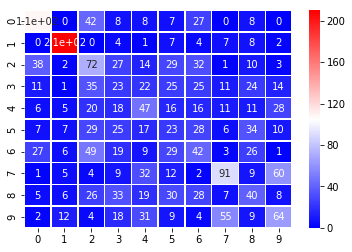

In [17]:
fit_random_forest_classifier(X_pca, y)

So, let's look at the positives first... that was super fast.  But clearly two components isn't giving us enough information to clearly identify the digits.  Let's consider a few more components, and take a closer look at what we know about the components.

In [18]:
pca.components_.shape

(2, 784)

In [19]:
def plot_components(X, y):
    '''
    plots the data in a 2 dimensional space to view separation
    INPUT: pretty straightforward again
    OUTPUT: none
    '''
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(10, 6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), fontdict={'size': 15})

    plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])
    

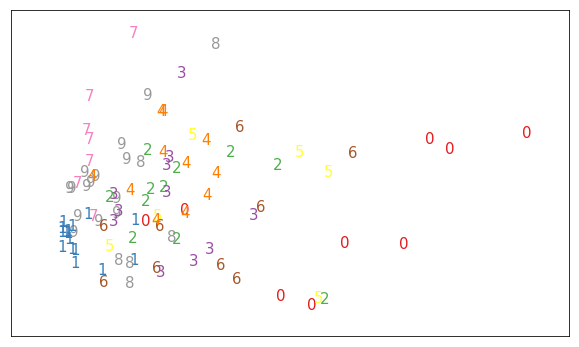

In [20]:
plot_components(X_pca[:100], y[:100])

In [22]:
X_pca.shape

(6304, 2)

In [23]:
X.shape

(6304, 784)